In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
from sqlalchemy import create_engine, func, inspect, desc
# Getting the table names for each table
inspector = inspect(engine)
inspector.get_table_names()

# Get a list of column names and types - measurements
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

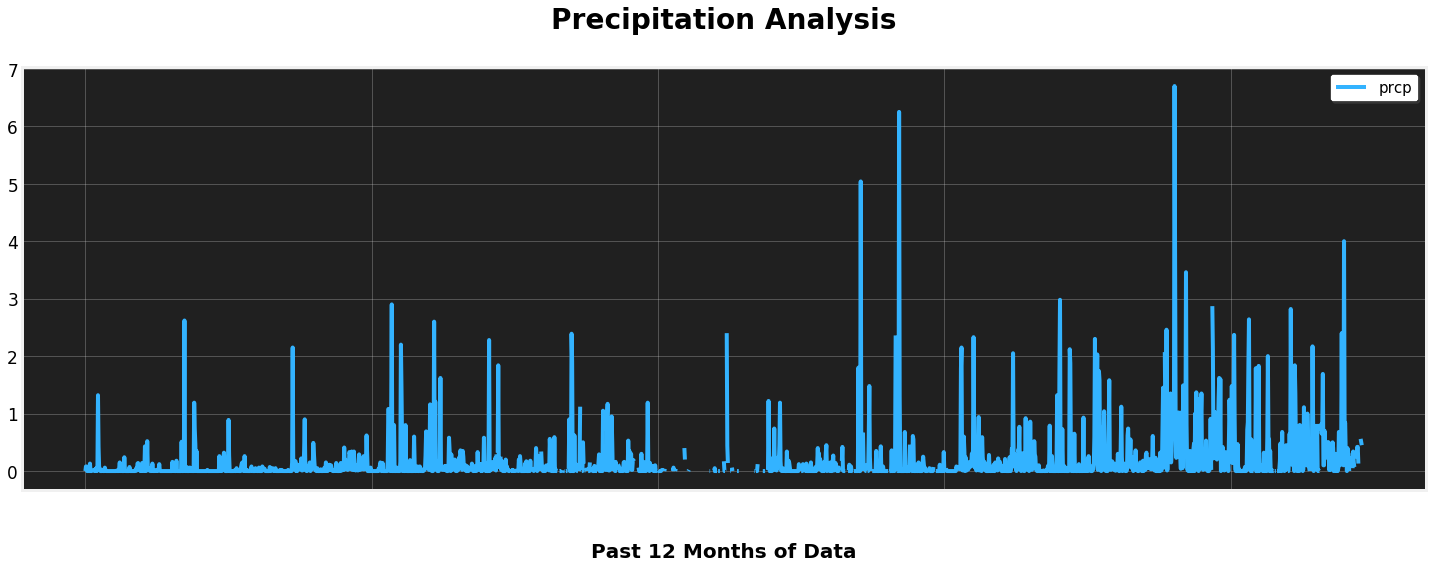

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
measurements_query = (session
                      .query(Measurement.date, 
                             Measurement.prcp)
                      .filter(Measurement.date <= '2017-08-23')
                      .filter(Measurement.date >= '2016-08-23')
                      .all())

# for row in measurements_query:
#     print(row)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(measurements_query, columns=['date', 'prcp'])

df.set_index('date', inplace=True)
df.head()

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot.line(y="prcp",figsize=(20,8), fontsize=17, color="#33B3FF")
ax.patch.set_facecolor("#000000")
ax.set_xlabel(xlabel="\n\nPast 12 Months of Data", fontsize=20, color="#000000", fontweight="bold")
ax.set_frame_on(b=True)
ax.set_facecolor("#202020")
ax.grid(True, alpha=.3)
ax.legend(frameon=True, fancybox=True, facecolor="#FFFFFF", edgecolor="#000000", shadow=True, loc="best", fontsize=15, mode="exapnd")
ax.label_outer()
ax.set_title("Precipitation Analysis\n", fontsize=28, color="#000000", fontweight="bold")
plt.tight_layout()
plt.savefig("prcp_analysis.png")


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Design a query to show how many stations are available in this dataset?
station_query = engine.execute("Select count(station) from Measurement").fetchall()
station_query

[(19550,)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_df = pd.read_sql("SELECT s.station, count(m.station) as station_count FROM measurement m, station s WHERE m.station=s.station GROUP BY m.station ORDER BY station_count DESC", con=engine, columns=[["station"],["station_count"]])
active_df

,station,station_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [29]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# best_station = active_df[active_df[station] == "USC00519281"]
# session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
#                 filter(Measurement.station == best_station).all()
q = session.query(Station.id,
                  Station.name,
                  func.min(Measurement.tobs),
                  func.max(Measurement.tobs),
                  func.avg(Measurement.tobs))\
.filter(Measurement.station == Station.station)\
.filter(Measurement.station == "USC00519281")

q.all()

[(7, 'WAIHEE 837.5, HI US', 54.0, 85.0, 71.66378066378067)]

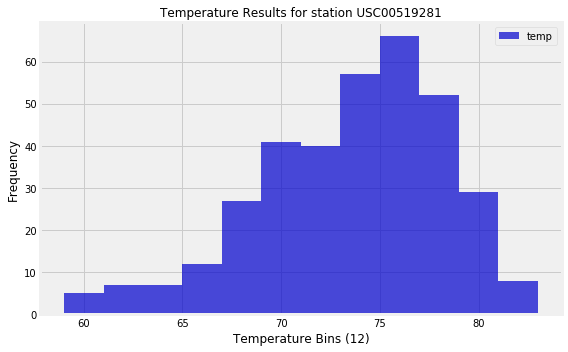

In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_twelve = session.query(Measurement.tobs)\
    .filter(Measurement.date > '2016-08-23')\
    .filter(Measurement.station == "USC00519281")\
    .order_by(Measurement.tobs).all()
    
# for row in tobs_twelve:
#     print(row)

tobs_df = pd.DataFrame(tobs_twelve, columns=['temp'])
tobs_df.head()

plt.subplots(figsize=(8,5))

plt.hist(tobs_df['temp'], bins=12, color="mediumblue", alpha=.7)
plt.title(f"Temperature Results for station USC00519281",fontsize=12)
plt.xlabel('Temperature Bins (12)', fontsize=12)
plt.ylabel("Frequency", fontsize=12)
labels = ['temp']
plt.legend(labels)
plt.gcf().subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.savefig('temperature_results_hist.png')
plt.show()

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_results = calc_temps('2016-11-02', '2016-11-15')
trip_results

[(63.0, 74.25842696629213, 79.0)]

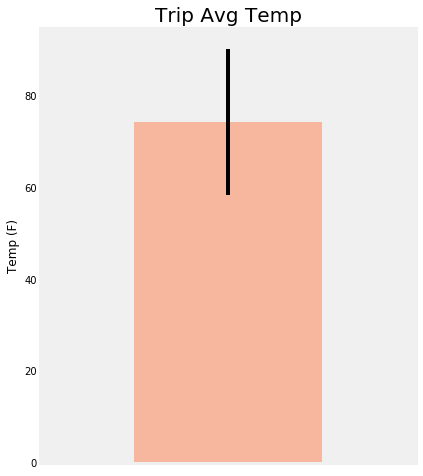

In [33]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("TripTempSummary.png")
plt.show()

In [34]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

station_trip = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= '2016-11-02')\
.filter(Measurement.date <= '2016-11-15')\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

station_trip.all()

[('USC00516128',
  1.2500000000000002,
  'MANOA LYON ARBO 785.2, HI US',
  152.4,
  21.3331,
  -157.8025),
 ('USC00514830',
  0.37,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  7.0,
  21.5213,
  -157.8374),
 ('USC00519281',
  0.36,
  'WAIHEE 837.5, HI US',
  32.9,
  21.45167,
  -157.84888999999998),
 ('USC00513117', 0.32, 'KANEOHE 838.1, HI US', 14.6, 21.4234, -157.8015),
 ('USC00519523',
  0.16999999999999998,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  19.5,
  21.33556,
  -157.71139),
 ('USC00519397', 0.07, 'WAIKIKI 717.2, HI US', 3.0, 21.2716, -157.8168),
 ('USC00517948', 0.02, 'PEARL CITY, HI US', 11.9, 21.3934, -157.9751)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
